In [32]:
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore
from scipy import stats

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore
from dowhy.gcm.shapley import ShapleyConfig, ShapleyApproximationMethods # type: ignore

In [66]:
df = pd.read_csv("../data/processed/data.csv")

In [67]:
# Impute missing values
df.rename(columns={'Product_price': 'revenue'}, inplace=True) 
df['Product_price'] = df['revenue'] + df['freight_value']
df['Product_weight_kg'] = df['Product_weight_kg'].fillna(df['Product_weight_kg'].mean())
df['distance_km'] = df['distance_km'].fillna(df['distance_km'].mean())
df['Product_size'] = df['Product_size'].fillna(df['Product_size'].mean())
df['customer_avg_score'] = df['customer_avg_score'].fillna(df['customer_avg_score'].mean())
df['No_photos'] = df['No_photos'].fillna(df['No_photos'].mean())
df['Product_price'] = df['Product_price'].fillna(df['Product_price'].mean())
df['freight_value'] = df['freight_value'].fillna(df['freight_value'].mean())
df['Rating'] = df['Rating'].round()
df['Product_category'] = df['Product_category'].fillna(df['Product_category'].mode()[0])
df['revenue'] = df['revenue'].fillna(df['revenue'].mean())

**DAG**

In [68]:
mapping_dict = {'Rating': 'discrete',
                'Product_category_encoded': 'categorical',
                'freight_value': 'continuous',
                'distance_km': 'continuous' ,
                'season': 'categorical' ,
                'is_delivery_late': 'categorical'}

# nodes
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'is_delivery_late'
]
# edges
edges_list = [
    ('season', 'Rating'),
    ('season', 'is_delivery_late'),
    ('season', 'Product_category_encoded'),
    ('is_delivery_late', 'Rating'),
    ('Product_category_encoded', 'is_delivery_late'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'freight_value'),
    ('Product_category_encoded', 'Rating'),
    ('freight_value', 'is_delivery_late'),
    ('freight_value', 'Rating'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'Rating'),
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

---
#### Causal Mechanism Assignment

**Structural Causal Model (SCM)** 

limits mechanisms to deterministic functional causal models of the form $X_i = f_i(\text{PA}_i, N_i)$, where $PA_i$ represents parent nodes and $N_i$ denotes unobserved noise.

While $N_i$ is unobserved during model fitting, it can be used as input when provided.

**Root Nodes**
- **Empirical Distribution**: Random sampling from provided data

**Non-Root Nodes**

1. **Continuous Data - Additive Noise Models (ADM)**
   - $X_i = f(PA_i) + N_i$
   - Selection: Minimizing mean squared error

2. **Discrete Data - Discrete ADM**
   - Like continuous ADM, but f returns discrete values
   - Evaluation: Mean Squared Error (MSE)

3. **Categorical Data - Classifier-based Model**
   - $X_i = f(PA_i, N_i)$, where $N_i$ ~ U[0,1]
   - Selection: Optimizing F1 score


[Estimating Causal Effect Using GCM](https://www.pywhy.org/dowhy/v0.11.1/user_guide/causal_tasks/estimating_causal_effects/effect_estimation_with_gcm.html)

In [71]:
rng = np.random.default_rng()
causal_model = gcm.StructuralCausalModel(G)

for node in G.nodes:

    # grabbing node's parents if any
    parents = set(G.predecessors(node))

    # if node is a root
    if len(parents) == 0:
        random_mean = rng.normal()
        random_scale = abs(rng.normal())
        emp_dist = gcm.ScipyDistribution(stats.norm, loc=random_mean, scale=random_scale)
        causal_model.set_causal_mechanism(node=node, mechanism=emp_dist)

    else:
        node_type = mapping_dict[node]
        if node_type == 'discrete':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_regressor()))
        elif node_type == 'categorical':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_classifier())) 
        else:
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_linear_regressor())) 

gcm.fit(causal_model, df)


discrete||Rating
categorical||Product_category_encoded
continuous||freight_value
categorical||is_delivery_late


Fitting causal mechanism of node is_delivery_late: 100%|██████████| 6/6 [00:29<00:00,  4.87s/it]        


In [73]:
sample_mean_list = []
num_iter = 100

for i in range(num_iter):
    random_sample = gcm.draw_samples(causal_model=causal_model, num_samples=100000)
    treatment = random_sample[random_sample['is_delivery_late'] == 1]['Rating'].mean()
    control = random_sample[random_sample['is_delivery_late'] == 0]['Rating'].mean()
    ate = treatment - control
    sample_mean_list.append(ate)

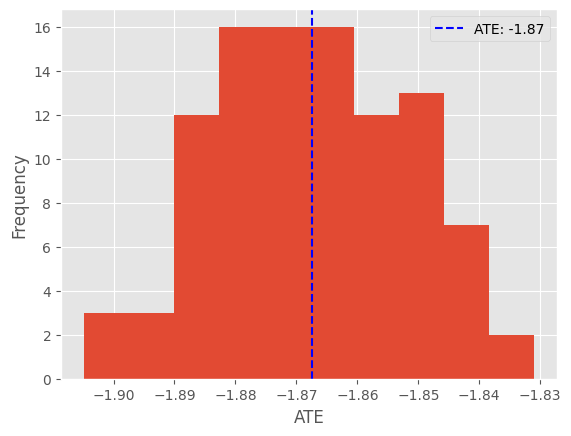

In [80]:
plt.style.use('ggplot')
plt.hist(sample_mean_list)
plt.axvline(np.mean(sample_mean_list), linestyle='dashed', color='blue', label=f'ATE: {round(np.mean(sample_mean_list),2)}')
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Quantifying Intrinsic Causal Influence

In [96]:
iccs_late_deliveries = gcm.intrinsic_causal_influence(causal_model=causal_model, 
                               target_node='Rating',
                               num_training_samples=10000,
                               num_samples_randomization=100,
                               shapley_config=ShapleyConfig(approximation_method=ShapleyApproximationMethods.PERMUTATION, num_permutations=100)
                               )

Evaluate set function: 62it [00:05, 11.09it/s]


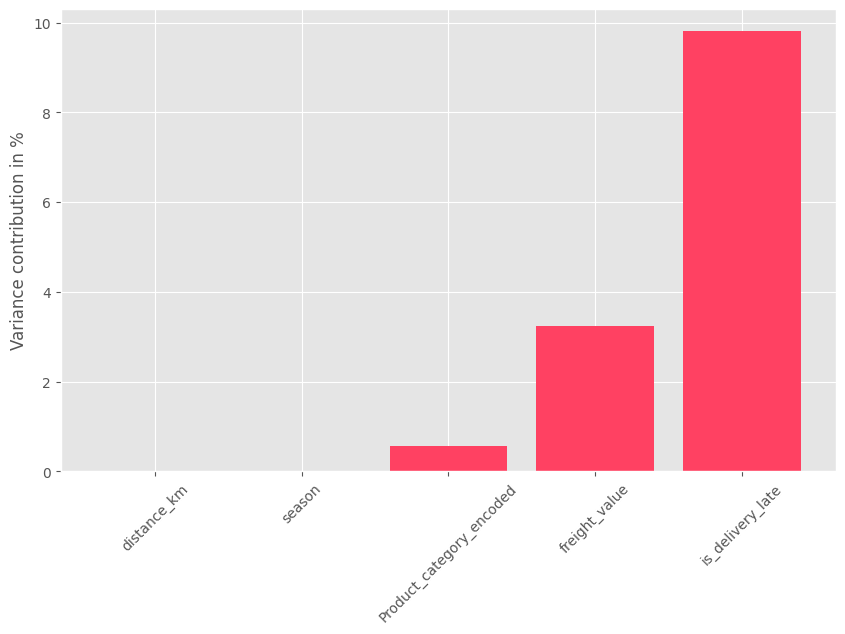

In [98]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

plt.figure(figsize=(10,6))
plt.bar(list(convert_to_percentage(iccs_late_deliveries).keys())[:-1], list(convert_to_percentage(iccs_late_deliveries).values())[:-1], color='#FF4162')
plt.ylabel("Variance contribution in %")
plt.xticks(rotation=45)
plt.show()